## Imports and Installing Dependencies

In [1]:
!pip install tensorflow_text
import tensorflow_text as text  # Registers the ops.


# After running this cell, we have to restart the Kernel and after restarting run this cell once again!

2024-04-05 16:50:26.404687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 16:50:26.404744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 16:50:26.406072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [23]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

## Loading the modified dataframes

In [24]:
train_df = pd.read_csv("/kaggle/input/train-df/train_df.csv")
valid_df = pd.read_csv("/kaggle/input/valid-df/valid_df.csv")
test_df = pd.read_csv("/kaggle/input/test-df/test_df.csv")

In [25]:
print(train_df.shape, valid_df.shape, test_df.shape)

(7200, 2) (800, 2) (2000, 2)


In [26]:
X_train = train_df["text"]
y_train = train_df["label"]

X_valid = valid_df["text"]
y_valid = valid_df["label"]

print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

(7200,)
(7200,)
(800,)
(800,)


## Building a BERT classification model

checking the tokenization process

In [27]:
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")

# Tokenize the input text
input_text = ["Hello, how are you?"]
tokenized_output = preprocessor(input_text)

# Print token IDs
print(tokenized_output['input_word_ids'])
print(tokenized_output['input_mask'])
print(tokenized_output['input_type_ids'])

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...


tf.Tensor(
[[ 101 7592 1010 2129 2024 2017 1029  102    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]], shape=(1, 128), dtype=int32)
tf.Tensor(
[[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 128), dty

In [28]:
# Building the model

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].





# Classification
# Add dropout layer
drop1 = tf.keras.layers.Dropout(0.2)(pooled_output)

# Add hidden dense layers
hidden1 = tf.keras.layers.Dense(128, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.2)(hidden1)
hidden2 = tf.keras.layers.Dense(32, activation='relu')(drop2)
drop3 = tf.keras.layers.Dropout(0.2)(hidden2)

# Output layer
output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop3)


model=tf.keras.Model(inputs=[text_input],outputs=[output_layer])

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...
Attaching model 'tensorflow/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2' to your Kaggle notebook...


## Fine-tuning the BERT model

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-6),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = tf.keras.metrics.BinaryAccuracy())
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_4 (KerasLayer)  {'input_word_ids': (None,    0         ['input_2[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [30]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',  # Path to save the best model
        save_best_only=True,  # Save only the best model
        monitor='val_binary_accuracy',  # Quantity to be monitored
        save_weights_only=True,  # Do not save the entire model
        verbose=1,  # Verbosity mode. 0 or 1.
        save_freq='epoch'  # Save the model at the end of every epoch
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=10,  # Number of epochs with no improvement after which training will be stopped
        monitor='val_binary_accuracy',  # Quantity to be monitored
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_binary_accuracy',  # Quantity to be monitored
        factor=0.5,  # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-7  # Lower bound on the learning rate
    )
]

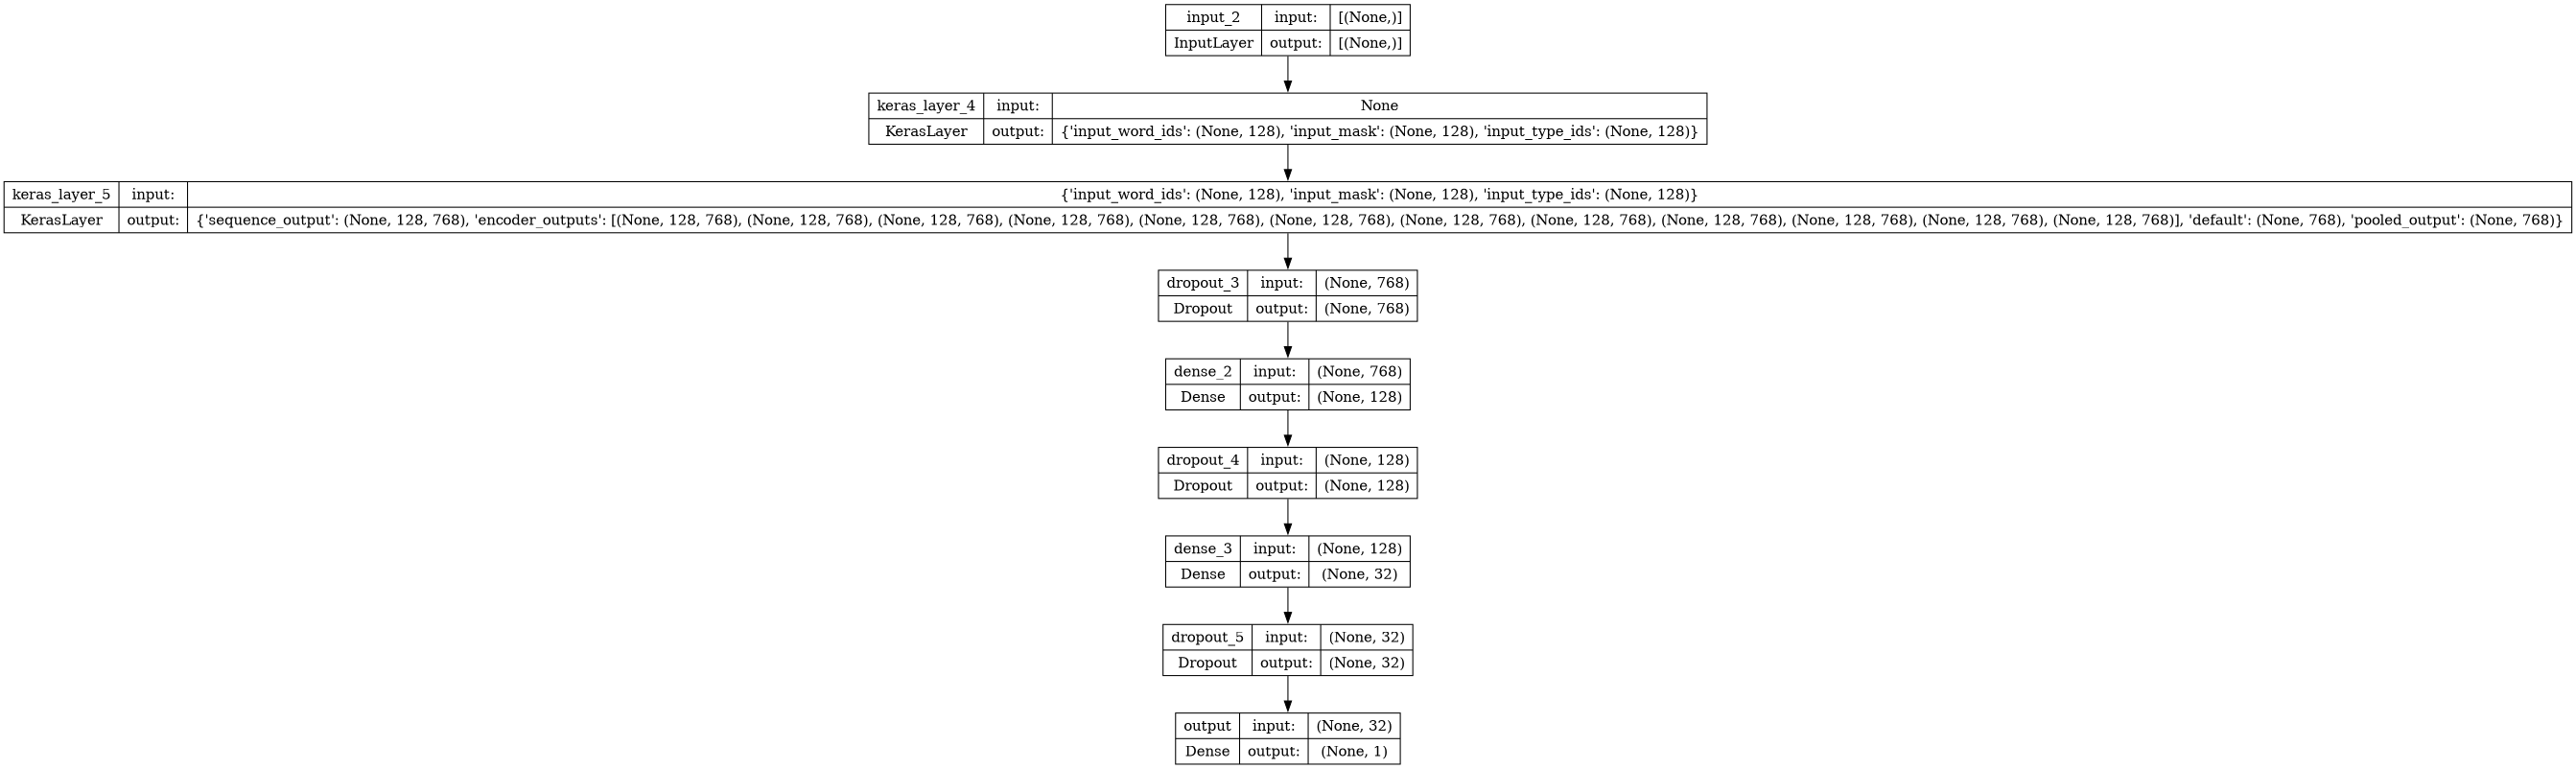

In [ ]:
# Plot the model architecture
tf.keras.utils.plot_model(model, show_shapes=True, dpi=76)

In [12]:
# Train model
epochs = 10
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_valid, y_valid),
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks
                   )

Epoch 1/10


I0000 00:00:1712335986.203813     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 [==============================] - ETA: 0s - loss: 0.6820 - binary_accuracy: 0.5872
Epoch 1: val_binary_accuracy improved from -inf to 0.62000, saving model to best_model.h5
225/225 [==============================] - 162s 544ms/step - loss: 0.6820 - binary_accuracy: 0.5872 - val_loss: 0.6568 - val_binary_accuracy: 0.6200 - lr: 2.0000e-06
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 0.6561 - binary_accuracy: 0.6240
Epoch 2: val_binary_accuracy did not improve from 0.62000
225/225 [==============================] - 120s 533ms/step - loss: 0.6561 - binary_accuracy: 0.6240 - val_loss: 0.6622 - val_binary_accuracy: 0.6200 - lr: 2.0000e-06
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 0.6420 - binary_accuracy: 0.6404
Epoch 3: val_binary_accuracy improved from 0.62000 to 0.65250, saving model to best_model.h5
225/225 [==============================] - 121s 538ms/step - loss: 0.6420 - binary_accuracy: 0.6404 - val_loss: 0.6273 - val_bina

## Visualing Loss Curves

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

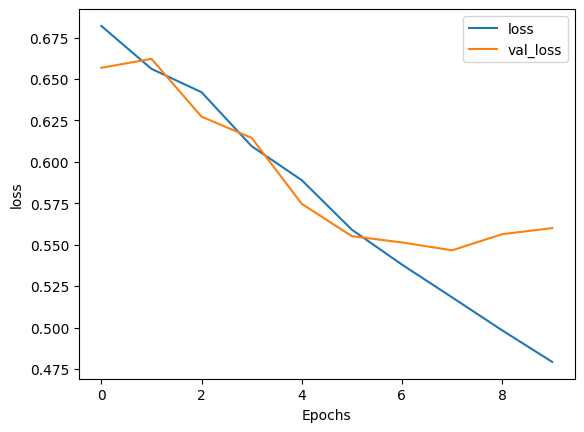

In [14]:
plot_graphs(history, 'loss')

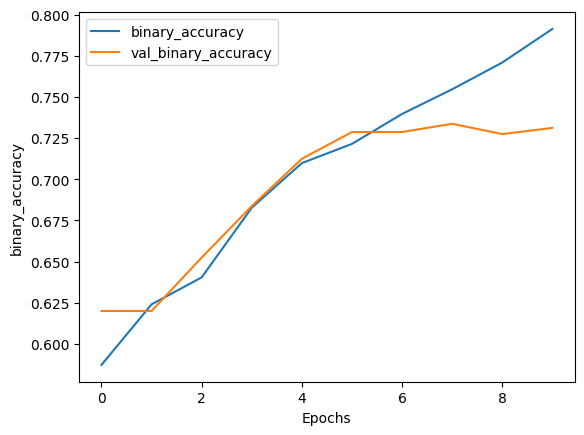

In [15]:
plot_graphs(history, 'binary_accuracy')

## Evaluation on Test Data

In [16]:
test_df.head(5)

,text,label
0,Meme Text: 'i did nazi that bird fly by did yo...,0
1,Meme Text: 'best holiday gift for muslims'Imag...,0
2,Meme Text: 'found a picture of your mother's w...,1
3,Meme Text: 'bruce jenner's cat'Image Caption: ...,0
4,Meme Text: 'i do not want to hear anymore abou...,0


In [17]:
X_test = test_df["text"]
y_test = test_df["label"]
print(X_test.shape)
print(y_test.shape)

(2000,)
(2000,)


In [18]:
y_predict=model.predict(X_test)

63/63 [==============================] - 13s 196ms/step


In [19]:
y_predict.shape

(2000, 1)

In [20]:
threshold = 0.5
y_pred = [1 if pred[0]>=threshold else 0 for pred in y_predict]

In [21]:
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy on test data:", round(accuracy*100, 4), "%")

Accuracy on test data: 73.5 %


In [22]:
auc_score = roc_auc_score(y_test, y_pred)

# Print the AUC score
print("AUC Score on test data:", round(auc_score, 4))

AUC Score on test data: 0.6974
